# MIP Model of the TSP
## Import Packages & Checks

In [1]:
import sys
import numpy as np
import math
import random

import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum

import matplotlib.pyplot as plt

In [2]:
print(sys.version)

3.6.12 |Anaconda, Inc.| (default, Sep  8 2020, 17:50:39) 
[GCC Clang 10.0.0 ]


## Define Classes

### Customer Nodes

In [3]:
class customer:
    '''===================
    Single Customer Class:
    ======================
    A customer is characterized by 
    - a (unique) ID
    - a location (x and y coordiantes)

    '''
    
    def __init__(self,
                x,
                y,
                cust_ID):         # customer ID

        self.cust_ID = str(cust_ID)
        self.x = float(x)
        self.y = float(y)
        self.loc = (self.x,self.y)
        

## Define Functions

### Compute Distance Matrix

In [4]:
def calc_dist(orig,dest):
    '''===================
    Distance Function:
    ======================

    Inputs:
    - orig : customer object : customer from which the distance is measured
    - dest : customer object : customer to which the distance is measured
    
    Outputs:
    - Distance (here: Euclidian) between the origina nd destination customer
    
    '''
    return math.sqrt((orig[0]-dest[0])**2+(orig[1]-dest[1])**2)


In [5]:
def d_matrix(customers):
    '''===================
    Distance Matrix Function:
    ======================

    Inputs:
    - customers : dictionary of customer objects : customers between which distances are measured
    
    Outputs:
    - Matrix of distances (here: Euclidian) between all possible customer pairs
    
    '''
    return dict(
        [((i,j),calc_dist(customers[i].loc,customers[j].loc)) 
         for i in customers for j in customers]
    )

### Plot Customers and TSP Path

In [6]:
def print_cust(customers):
    '''===================
    Print Customers Function:
    ======================

    Inputs:
    - customers : dictionary of customer objects : customers between which distances are measured
    
    Outputs:
    - None
    
    '''
    
    # Plot customer locations
    x = [customers[i].x for i in customers]
    y = [customers[i].y for i in customers]

    plt.scatter(x, y)
    plt.show()

In [7]:
def print_TSP(customers,X):
    '''===================
    Print TSP Function:
    ======================

    Inputs:
    - customers : dictionary of customer objects : customers between which distances are measured
    - X : dictionary of Gurobi decision variables : routing decisions in the optimal solution
    
    Outputs:
    - None
    
    '''
    
    # Extract the vehicle trajectory from the optimal solution to the TSP
    # 1. Set (arbitrary) custoemr to start the trajectory at
    i = "C_1"
    # 2. Determine x and y coordinates of that customer and record them
    locslist_x = [customers[i].x]
    locslist_y = [customers[i].y]
    # 3. Record that you have visited one ciustomer already
    n_done = 1
    
    # 4. While you have not yet visited all customers (i.e., no full circle)
    while n_done <= n_customers:
        # - Find next customer along the optimal TSP path
        for j in customers:
            if ((i,j) in X) and (round(X[(i,j)].x) == 1):
                # - Determine x and y coordinates of that customer and record them
                locslist_x.append(customers[j].x)
                locslist_y.append(customers[j].y)
                # - Record that this is now the last visited customer
                i = j
                # - Increase the number of customers visited
                n_done = n_done+1
                # - Break out of this For Loop, since you found the next customer
                break

    # Plot customer locations
    x = [customers[i].x for i in customers]
    y = [customers[i].y for i in customers]
    plt.scatter(x, y)
    # Plot TSP path between them
    plt.plot(locslist_x, locslist_y, 'ro-')
    plt.show()
    

## Initialize Problem

Basic Parameters

In [8]:
# Number of customers
n_customers = 30

# Dimensions of the demand area
area_width = 100
area_height = 100

Customers

In [9]:
# Here: 
# - randomly generate n customer locations
# - create custumer objects for each customer
customers = dict(
[("C_"+str(i+1), customer(random.uniform(0,area_width),random.uniform(0,area_height),"C_"+str(i+1))) 
 for i in range(n_customers)]
)

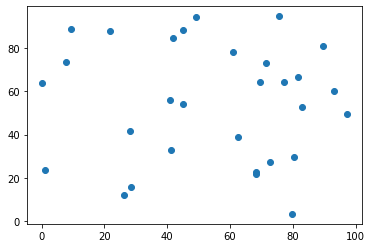

In [10]:
#Plot the customer locations
print_cust(customers)

Distances

In [11]:
# Compute distance matrix between these customers
distances = d_matrix(customers)

## Build Gurobi Model

__Initialize New Gurobi Model__

In [12]:
# Initialize new Gurobi Model
m = gp.Model("TSP")

Academic license - for non-commercial use only - expires 2021-04-18
Using license file /Users/mwinkenb/gurobi.lic


__Add Decision Variables__

- Routing variables (binary)
- Auxiliary variables (integer)

In [13]:
# Create variables:

# - Routing decisions on arcs of the network
X = dict(
    [((i,j), m.addVar(vtype=GRB.BINARY, name="x_%s_%s" %(i,j))) 
     for i in customers for j in customers]
)

# - Auxiliary variables for sub-tour elimination
U = dict(
    [(list(customers)[i], m.addVar(vtype=GRB.INTEGER, name="u_%s" %list(customers)[i])) 
     for i in range(len(customers)) if i+1 >= 2]
)

__Set Optimization Objective__

Minimize total distance travelled

In [14]:
# Set objective: minimize total TSP distance
m.setObjective(
    quicksum([distances[(i,j)]*X[(i,j)] 
              for i in customers 
              for j in customers if j != i]), 
    GRB.MINIMIZE)

__Add Constraints__

In [15]:
# Add constraints:
# - Flow conservation constraints
Flow_cons_1 = dict(
    [(j,m.addConstr(quicksum([X[(i,j)] for i in customers if i != j]) == 1, "single_in_%s" %j)) 
     for j in customers]
)

Flow_cons_2 = dict(
    [(j,m.addConstr(quicksum([X[(j,i)] for i in customers if i != j]) == 1, "single_out_%s" %j)) 
     for j in customers]
)

# - Subtour elimination constraints
Subtour = dict(
    [((i,j),m.addConstr(U[i]-U[j]+n_customers*X[(i,j)] <= n_customers-1, "subtour_%s_%s" %(i,j))) 
     for i in customers for j in customers if (i != "C_1" and j != "C_1" and i != j)]
)

# - restricting the variable domains
Domain_1 = dict(
    [(i,m.addConstr(U[i] <= n_customers-1, "u_domain_ub_%s" %i)) 
     for i in customers if i != "C_1"]
)

Domain_2 = dict(
    [(i,m.addConstr(U[i] >= 0, "u_domain_lb_%s" %i)) 
     for i in customers if i != "C_1"]
)

__Run Optimization Model__

In [16]:
# Set model parameters
m.Params.timelimit = 300.0 # run for at most 300 seconds
m.Params.MIPGap = 0.001 # terminate once a 0.01% optimality gap is reached

# Optimize model
m.optimize()

Changed value of parameter timelimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter MIPGap to 0.001
   Prev: 0.0001  Min: 0.0  Max: inf  Default: 0.0001
Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 930 rows, 929 columns and 4234 nonzeros
Model fingerprint: 0xd79101ee
Variable types: 0 continuous, 929 integer (900 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [9e-01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 58 rows and 30 columns
Presolve time: 0.01s
Presolved: 872 rows, 899 columns, 4176 nonzeros
Variable types: 0 continuous, 899 integer (870 binary)
Found heuristic solution: objective 1478.4941462

Root relaxation: objective 3.884223e+02, 93 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |

__Plot Solution__

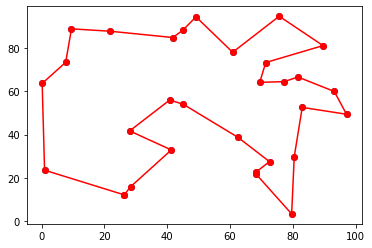

Total Cost: 466.073


In [17]:
# Plot solution
print_TSP(customers,X)
# Print total cost
print('Total Cost: %g' % m.objVal)